<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tqdm
import cvxpy as cp
import numpy as np


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_inv, p):  # S is the matrix such that ||S @ Dx||\leq delta. As a consequence, S_inv appears in the unconstrained problem
        m, n = X.shape
        q = compute_q(p)
        # Formulate problem
        param = cp.Variable(n)
        param_norm = cp.pnorm(S_inv @ param, p=q)
        adv_radius = cp.Parameter(name='adv_radius', nonneg=True)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / m * cp.sum((abs_error + adv_radius * param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius = adv_radius
        self.param = param
        self.warm_start = False

    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, **kwargs)
            v = self.param.value
        except:
            v = np.zeros(self.param.shape)
        return v


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []


def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        #print("alpha  ", a)
        coefs = estimator(X, y, a)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T


def plot_coefs(alphas, coefs, ax):
    colors = cycle(["b", "r", "g", "c", "k"])
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    colors = cycle(["b", "r", "g", "c", "k"])
    l1norm = np.abs(coefs).mean(axis=0)
    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)

#X, y = datasets.load_diabetes(return_X_y=True)
#print(X.shape, y.shape)
# Standardize data


#M = np.sum(masks, axis=1)
#X_nan = X.copy()
#X_nan[masks == 1] = np.nan

#X = multiple_imputation(1, X_nan)
print("end block")


end block


In [15]:
# imputation's block

def clear_dataset(x, masks):
  # remove observations full NaN
  M = np.sum(1 - masks, axis=1) > 0
  return x[M, :], masks[M, :]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res ", res)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      #print(m_bool)
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      #print("matrices computed")
      #print(sigma_aa_inv)
      #print(sigma_ma)
      #print("wee", x_c[m_bool])
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      #print("mu cond ", mu_cond)
      x_imp[i, ~m_bool] = mu_cond
    #print("x_orig \n", x)
    #print("x_imp \n", x_imp)
    #print("diff\n", x - x_imp)
  return x_imp

#n = 3
#d = 4
#S = np.random.randint(low=1, high=10, size=(d, d))
#S = S.T @ S * 0 + np.eye(d)
#print(S)
#muu = np.array([10, 20, 30, 40])
#xx = np.random.randint(low=1, high=6, size=(n, d))
#mm = np.array([[0, 0, 0, 0], [1, 1, 1, 1], [0, 0, 1, 1]])
#print(xx)
#print(mm)
#x, m = clear_dataset(xx, mm)
#print("cleaned ds \n", x)
#print("cleaned masks \n", mm)
#res = imputation_elliptic(muu, S, x, m)


In [16]:
# define observations

n = 400
d = 6
X_orig = np.random.rand(n, d)
#X -= X.mean(axis=0)
#X /= X.std(axis=0)
b = np.random.rand(d)

#L = np.linalg.cholesky(S)  # return L such that S = LL.T
#L_inv = np.linalg.inv(L)
#S_inv = L_inv.T @ L_inv

masks = np.random.binomial(1, 0.25, (n, d))  # 1 missing, 0 seen

X_orig, masks = clear_dataset(X_orig, masks)
print("final shape ", X_orig.shape)
y = X_orig @ b
X_nan = X_orig.copy()
X_nan[masks == 1] = np.nan
print("end block")

final shape  (400, 6)
end block


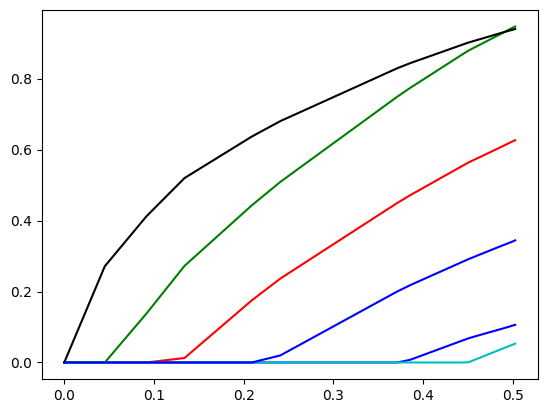

In [17]:
## original lasso
fig, ax = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_orig, y)
plot_coefs_l1norm(coefs_lasso, ax)

 72%|███████▏  | 143/200 [00:02<00:01, 49.48it/s]/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 200/200 [00:31<00:00,  6.39it/s]


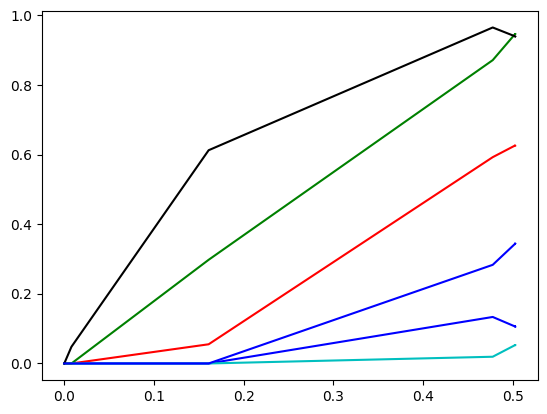

In [18]:
# training with original dataset X_orig
fig, ax = plt.subplots(num='advtrain_linf')
linfadvtrain = AdversarialTraining(X_orig, y, np.eye(X_orig.shape[1]), p=np.inf)
estimator = lambda X, y, a:  linfadvtrain(adv_radius=a)
alphas_adv, coefs_advtrain_linf  = get_path(X_orig, y, estimator, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf, ax)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


(400, 6)
std_orig: 
 [0.28972627 0.2801223  0.28252783 0.28753911 0.28777565 0.29005812]
std rf
  [0.26556125 0.25725175 0.26586782 0.26828349 0.26120986 0.26522763]


 88%|████████▊ | 175/200 [00:13<00:09,  2.73it/s]/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 200/200 [00:30<00:00,  6.58it/s]


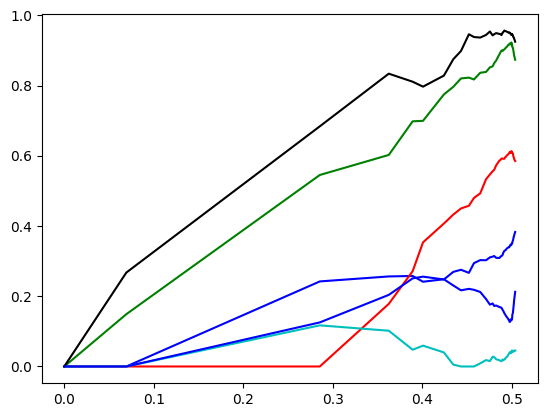

In [19]:
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
#print("S_inv std_rf \n", np.diag(1 / sd_rf))
#print("diag matr std \n", np.diag(sd_rf))
#print(X_orig)
#print(masks)
#print(X_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)


std_orig: 
 [0.29266509 0.28757933 0.28824084 0.29070611 0.29620619 0.28801247]
std  br
  [0.2585198  0.24422121 0.24629464 0.25618916 0.25449573 0.2435411 ]


  1%|          | 2/200 [00:00<00:10, 19.79it/s]

alpha   0.0001
alpha   0.0001059560179277616
alpha   0.00011226677735108136
alpha   0.00011895340673703195


  3%|▎         | 6/200 [00:00<00:12, 15.52it/s]

alpha   0.00012603829296797275
alpha   0.00013354515629298989
alpha   0.00014149912974345758
alpha   0.00014992684327860457


  9%|▉         | 18/200 [00:00<00:05, 32.39it/s]

alpha   0.00015885651294280528
alpha   0.00016831803533309567
alpha   0.00017834308769319092
alpha   0.00018896523396912096
alpha   0.00020022003718155845
alpha   0.00021214517849106298
alpha   0.00022478058335487252
alpha   0.00023816855519761583
alpha   0.0002523539170434766
alpha   0.0002673841615839947


 12%|█▎        | 25/200 [00:00<00:04, 42.86it/s]

alpha   0.0002833096101839324
alpha   0.0003001835813575589
alpha   0.0003180625692794119
alpha   0.00033700643292719284
alpha   0.00035707859649004625
alpha   0.0003783462617131929
alpha   0.0004008806328898465
alpha   0.00042475715525368984
alpha   0.00045005576757004977
alpha   0.00047686116977144693
alpha   0.0005052631065335679
alpha   0.0005353566677410725
alpha   0.0005672426068491978
alpha   0.0006010276782070381


 20%|█▉        | 39/200 [00:01<00:02, 54.62it/s]

alpha   0.0006368249944718586
alpha   0.0006747544053110693
alpha   0.0007149428986597577
alpha   0.0007575250258771912
alpha   0.0008026433522257174
alpha   0.0008504489341802677
alpha   0.0009011018251665018
alpha   0.0009547716114208056
alpha   0.001011637979766207
alpha   0.0010718913192051286
alpha   0.001135733358343105
alpha   0.0012033778407775906
alpha   0.0012750512407130128
alpha   0.0013509935211980279


 26%|██▋       | 53/200 [00:01<00:02, 60.22it/s]

alpha   0.0014314589375234786
alpha   0.001516716888470924
alpha   0.0016070528182616384
alpha   0.0017027691722259013
alpha   0.0018041864093920718
alpha   0.0019116440753857036
alpha   0.0020255019392306666
alpha   0.0021461411978584057
alpha   0.0022739657523579274
alpha   0.0024094035602395267
alpha   0.0025529080682395165
alpha   0.002704959730463137
alpha   0.0028660676169482502
alpha   0.0030367711180354605


 30%|███       | 60/200 [00:01<00:02, 60.05it/s]

alpha   0.0032176417502507355
alpha   0.0034092850697468144
alpha   0.0036123426997094303
alpha   0.003827494478516315
alpha   0.004055460735840828
alpha   0.004297004704320844


 34%|███▎      | 67/200 [00:01<00:03, 36.89it/s]

alpha   0.004552935074866948
alpha   0.004824108704165373
alpha   0.005111433483440166


 36%|███▌      | 72/200 [00:01<00:04, 29.96it/s]

alpha   0.005415871378079476
alpha   0.005738441648302393
alpha   0.006080224261649427
alpha   0.00644236350872137
alpha   0.006826071834272393
alpha   0.007232633896483534
alpha   0.007663410868007463


 42%|████▎     | 85/200 [00:02<00:02, 40.64it/s]

alpha   0.008119844993184008
alpha   0.00860346441668451
alpha   0.009115888299750819
alpha   0.009658832241158708
alpha   0.010234114021054537
alpha   0.010843659686896108
alpha   0.011489510001873097
alpha   0.012173827277396621
alpha   0.012898902612533094
alpha   0.013667163564620072
alpha   0.014481182276745346
alpha   0.015343684089300131


 48%|████▊     | 96/200 [00:02<00:02, 45.78it/s]

alpha   0.016257556664437952
alpha   0.017225859653987874
alpha   0.018251834943190444
alpha   0.01933891750455232
alpha   0.020490746898158482
alpha   0.021711179456945052
alpha   0.023004301197729192
alpha   0.024374441501222217
alpha   0.025826187606826773
alpha   0.02736439997074672


 51%|█████     | 102/200 [00:02<00:02, 44.62it/s]

alpha   0.02899422853882878
alpha   0.03072112998861759
alpha   0.0325508859983506
alpha   0.0344896226040576
alpha   0.03654383070957258
alpha   0.03872038781812557
alpha   0.04102658105827194
alpha   0.043470131581250265
alpha   0.04605922041145108


 56%|█████▋    | 113/200 [00:02<00:02, 41.78it/s]

alpha   0.04880251583654434
alpha   0.05170920242896761
alpha   0.05478901179593945
alpha   0.058052255160949015
alpha   0.06150985788580504
alpha   0.06517339604882427
alpha   0.0690551352016233
alpha   0.073168071434272
alpha   0.07752597488629465
alpha   0.0821434358491943
alpha   0.08703591361485166


 62%|██████▏   | 123/200 [00:03<00:02, 37.69it/s]

alpha   0.09221978823334331
alpha   0.09771241535346502
alpha   0.10353218432956626
alpha   0.1096985797892384
alpha   0.1162322468679853
alpha   0.12315506032928261
alpha   0.1304901978014403
alpha   0.13826221737646563
alpha   0.14649713983072862
alpha   0.1552225357427048


 64%|██████▍   | 128/200 [00:04<00:05, 13.53it/s]

alpha   0.16446761779946645
alpha   0.17426333860096507


 66%|██████▌   | 131/200 [00:04<00:06, 11.40it/s]

alpha   0.18464249428955445
alpha   0.19563983435170648
alpha   0.2072921779595372


 67%|██████▋   | 134/200 [00:05<00:08,  8.24it/s]

alpha   0.2196385372416547
alpha   0.23272024789604098
alpha   0.2465811075822604


 68%|██████▊   | 136/200 [00:05<00:09,  6.42it/s]

alpha   0.2612675225563329
alpha   0.27682866303920667


 70%|██████▉   | 139/200 [00:06<00:11,  5.27it/s]

alpha   0.29331662783900453
alpha   0.3107866187782014


 70%|███████   | 140/200 [00:06<00:11,  5.17it/s]

alpha   0.3292971255097151


 70%|███████   | 141/200 [00:07<00:11,  5.06it/s]

alpha   0.3489101213406774


 71%|███████   | 142/200 [00:07<00:13,  4.39it/s]

alpha   0.3696912707195028


 72%|███████▏  | 143/200 [00:08<00:16,  3.48it/s]

alpha   0.39171014908092605


 72%|███████▏  | 144/200 [00:08<00:22,  2.54it/s]

alpha   0.41504047578504766


 73%|███████▎  | 146/200 [00:09<00:16,  3.25it/s]

alpha   0.4397603609302721
alpha   0.4659525668664682


 74%|███████▎  | 147/200 [00:09<00:14,  3.61it/s]

alpha   0.4937047852839004


 74%|███████▍  | 148/200 [00:09<00:13,  3.78it/s]

alpha   0.5231099308056264


 75%|███████▌  | 150/200 [00:09<00:10,  4.56it/s]

alpha   0.5542664520663108
alpha   0.5872786613189482


 76%|███████▌  | 152/200 [00:10<00:08,  5.68it/s]

alpha   0.6222570836730231
alpha   0.6593188271333549


 77%|███████▋  | 154/200 [00:10<00:07,  5.78it/s]

alpha   0.698587974678525
alpha   0.7401959996915645


 78%|███████▊  | 156/200 [00:10<00:07,  5.79it/s]

alpha   0.7842822061337682
alpha   0.8309941949353395


 78%|███████▊  | 157/200 [00:11<00:07,  5.48it/s]

alpha   0.8804883581643465


 80%|███████▉  | 159/200 [00:11<00:07,  5.14it/s]

alpha   0.9329304026284686
alpha   0.9884959046625587


 80%|████████  | 160/200 [00:11<00:08,  4.81it/s]

alpha   1.0473708979594507


 80%|████████  | 161/200 [00:11<00:08,  4.69it/s]

alpha   1.1097524964120722


 81%|████████  | 162/200 [00:12<00:08,  4.24it/s]

alpha   1.175849554052158


 82%|████████▏ | 163/200 [00:12<00:09,  4.07it/s]

alpha   1.2458833642950082


 82%|████████▏ | 164/200 [00:12<00:09,  3.69it/s]

alpha   1.3200884008314195


 82%|████████▎ | 165/200 [00:13<00:09,  3.55it/s]

alpha   1.3987131026472386


 83%|████████▎ | 166/200 [00:13<00:10,  3.37it/s]

alpha   1.4820207057988601


 84%|████████▎ | 167/200 [00:13<00:10,  3.30it/s]

alpha   1.5702901247293775


 84%|████████▍ | 168/200 [00:14<00:10,  3.14it/s]

alpha   1.6638168860761307


 84%|████████▍ | 169/200 [00:14<00:10,  2.98it/s]

alpha   1.762914118095948


 85%|████████▌ | 170/200 [00:14<00:10,  2.92it/s]

alpha   1.8679135990207847


 86%|████████▌ | 171/200 [00:15<00:08,  3.27it/s]

alpha   1.9791668678535574


 86%|████████▌ | 172/200 [00:15<00:09,  2.84it/s]

alpha   2.097046401323235


 86%|████████▋ | 173/200 [00:15<00:09,  2.83it/s]

alpha   2.2219468609395236


 87%|████████▋ | 174/200 [00:16<00:09,  2.77it/s]

alpha   2.35428641432242


 88%|████████▊ | 175/200 [00:16<00:09,  2.59it/s]

alpha   2.4945081352303164


/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
 88%|████████▊ | 176/200 [00:17<00:09,  2.44it/s]

alpha   2.643081486974108


 88%|████████▊ | 177/200 [00:17<00:10,  2.29it/s]

alpha   2.800503894183631


 89%|████████▉ | 178/200 [00:18<00:09,  2.23it/s]

alpha   2.9673024081888726


 90%|████████▉ | 179/200 [00:18<00:09,  2.17it/s]

alpha   3.1440354715915


 90%|█████████ | 180/200 [00:19<00:09,  2.16it/s]

alpha   3.331294787934677


 90%|█████████ | 181/200 [00:19<00:09,  2.11it/s]

alpha   3.52970730273065


 91%|█████████ | 182/200 [00:20<00:09,  1.83it/s]

alpha   3.7399373024788014


 92%|█████████▏| 183/200 [00:21<00:10,  1.58it/s]

alpha   3.9626886387014784


 92%|█████████▏| 184/200 [00:22<00:10,  1.47it/s]

alpha   4.198707084443915


 92%|█████████▎| 185/200 [00:22<00:10,  1.41it/s]

alpha   4.448782831127585


 93%|█████████▎| 186/200 [00:23<00:08,  1.56it/s]

alpha   4.713753134116729


 94%|█████████▎| 187/200 [00:23<00:07,  1.69it/s]

alpha   4.99450511585514


 94%|█████████▍| 188/200 [00:24<00:06,  1.78it/s]

alpha   5.291978735958447


 94%|█████████▍| 189/200 [00:24<00:05,  1.86it/s]

alpha   5.607169938205458


 95%|█████████▌| 190/200 [00:25<00:05,  1.91it/s]

alpha   5.94113398496504


 96%|█████████▌| 191/200 [00:25<00:04,  1.96it/s]

alpha   6.294988990221888


 96%|█████████▌| 192/200 [00:26<00:04,  1.98it/s]

alpha   6.669919663030129


 96%|█████████▋| 193/200 [00:26<00:03,  2.02it/s]

alpha   7.067181273927491


 97%|█████████▋| 194/200 [00:27<00:02,  2.03it/s]

alpha   7.488103857590031


 98%|█████████▊| 195/200 [00:27<00:02,  2.05it/s]

alpha   7.934096665797492


 98%|█████████▊| 196/200 [00:28<00:01,  2.05it/s]

alpha   8.406652885618334


 98%|█████████▊| 197/200 [00:28<00:01,  2.06it/s]

alpha   8.907354638610439


 99%|█████████▉| 198/200 [00:29<00:00,  2.04it/s]

alpha   9.437878277775392


100%|█████████▉| 199/200 [00:29<00:00,  2.05it/s]

alpha   10.0


100%|██████████| 200/200 [00:30<00:00,  6.65it/s]


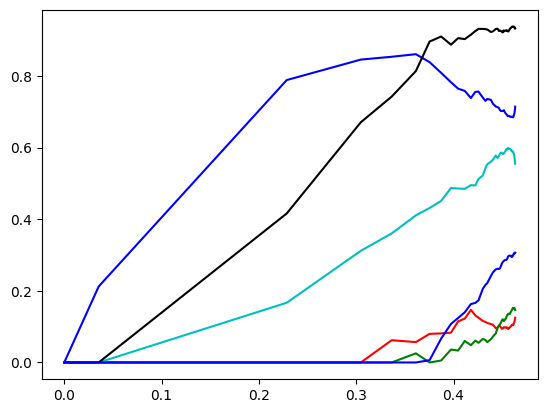

In [13]:
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)
#print("S_inv std_rf \n", np.diag(1 / sd_rf))
#print("diag matr std \n", np.diag(sd_rf))
#print(X_orig)
#print(masks)
#print(X_rf)
fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)

[0.25103942 0.24564808 0.25357298 0.25544257 0.24995347 0.25593842]


 88%|████████▊ | 175/200 [00:19<00:12,  1.97it/s]/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 200/200 [00:42<00:00,  4.72it/s]


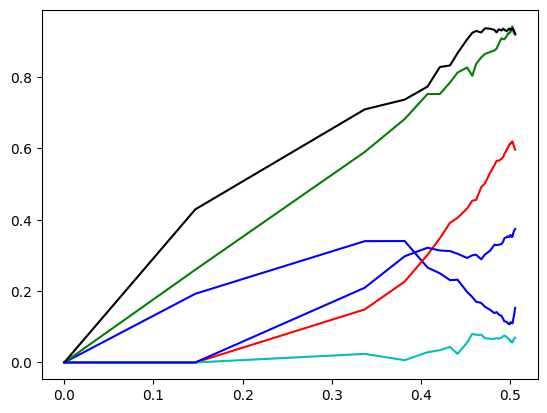

In [20]:
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

#print("S_inv std_rf \n", np.diag(1 / sd_rf))
#print("diag matr std \n", np.diag(sd_rf))
#print(X_orig)
#print(masks)
#print(X_rf)
fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)


In [ ]:
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
delta = np.mean(masks) # parameter missingness
print(delta)
X_0 = np.nan_to_num(X_nan)
S_ellp =  X_0.T @ X_0
#print("diag ", np.diag(np.diag(S)))
S_ellp = (1/d - 1/(d**2)) * np.diag(np.diag(S_ellp)) + 1/(d**2) * S_ellp
#print("matrix \n", S_ellp)
print(np.linalg.eigvalsh(S_ellp))
#print("X_nan\n", X_nan)
#print(masks)
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
#print(X_ellp)
S_inv_ellp = np.linalg.inv(S_ellp)
#S_inv_ellp = S_ellp

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_inv_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)


In [23]:
# mi bayesian ridge

# imputation elliptic

number_multiple_imputed_datasets = 3
X_imp = multiple_imputation(number_multiple_imputed_datasets, X_nan)
print(X_imp.shape)
print("wait for input")
input()
fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_inv_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)





TypeError: Cannot interpret '400' as a data type